# Forecasting air pollutant concentration

- In this notebook, we will forecast the CO concentration in the next hour. 

- We will train models using the features we created in the previous notebook

- We will compare the performance of a naive forecast, with random forests and linear regression.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

## Load data

In [2]:
# Load data (we created this file in the previous notebook)

data = pd.read_csv(
    "air_qual_preprocessed.csv",
    parse_dates=["Date_Time"],
    index_col=["Date_Time"],
)

data.head()

,CO_sensor,Month,Week,Day,Day_of_week,Hour,is_weekend,CO_sensor_lag_1,RH_lag_1,CO_sensor_lag_24,RH_lag_24,Month_sin,Month_cos,Hour_sin,Hour_cos
Date_Time,,,,,,,,,,,,,,,
2004-04-05 00:00:00,1065.0,4,15,5,0,0,0,1188.0,60.8,1224.0,56.5,0.866025,-0.5,0.000000,1.000000
2004-04-05 01:00:00,999.0,4,15,5,0,1,0,1065.0,65.8,1215.0,59.2,0.866025,-0.5,0.269797,0.962917
2004-04-05 02:00:00,911.0,4,15,5,0,2,0,999.0,79.2,1115.0,62.4,0.866025,-0.5,0.519584,0.854419
2004-04-05 03:00:00,873.0,4,15,5,0,3,0,911.0,80.0,1124.0,65.0,0.866025,-0.5,0.730836,0.682553
2004-04-05 04:00:00,881.0,4,15,5,0,4,0,873.0,81.0,1028.0,65.3,0.866025,-0.5,0.887885,0.460065


## Separate into train and test

We will train the model on a certain portion of the data and leave another part out to evaluate the model.

Because these are time series, I will split based on time. We leave the most recent data as test set.

In [3]:
# Find minimum and maximum dates.

data.index.min(), data.index.max()

(Timestamp('2004-04-05 00:00:00'), Timestamp('2005-04-04 14:00:00'))

In [4]:
# We will keep the last month of data to test
# the forecasting models.

X_train = data[data.index <= "2005-03-04"]
X_test = data[data.index > "2005-03-04"]

X_train.shape, X_test.shape

((6428, 15), (494, 15))

In [5]:
# the target variable
y_train = X_train["CO_sensor"].copy()
y_test = X_test["CO_sensor"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("CO_sensor", axis=1)
X_test = X_test.drop("CO_sensor", axis=1)

## Naive Forecast

- We will predict the pollutant's concentration at time t with its value at time t-1. 

- We will use this model as a benchmark.

In [7]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["CO_sensor_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["CO_sensor_lag_1"], squared=False,))

train rmse:  102.99696786276506
test rmse:  111.12015235369915


## Random Forests

In [8]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [11]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  99.75721333140793
test rmse:  108.18842299455355


Small uplift with respect to the Naive forecast. The predictions made by the Random Forests return smaller rmse.

## Linear Regression

Random Forest regression models are not very good at extrapolating values beyond those observed in the data. So let's now train a Lasso regression for comparison.

In [35]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [36]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  97.11920053790013
test rmse:  100.59365691841252


The linear regression model provides much better forecasts compared to the benchmark and to random forests.

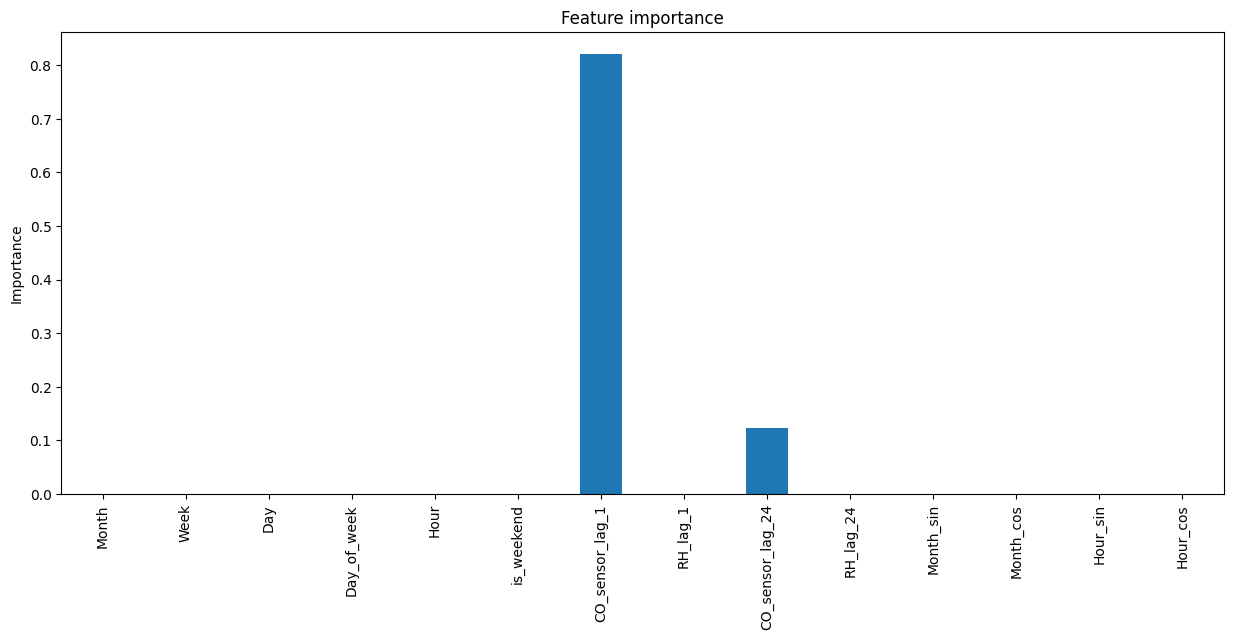

In [37]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance");

We see that the most important feature is the concentration of CO in the previous hour. But, the humidity in the previous hour also contributes to the CO concentration, as does the time of the day (CO_sensor_season), and the concentration of CO on the previous day and in the previous 3 hrs.